In [1]:
import os
import requests
from PIL import Image
from io import BytesIO
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [2]:
# Path to dataset
DATASET_PATH = "./"

# Load the CSV
csv_path = os.path.join(DATASET_PATH, "Scraped_Data_Plus_Type_And_Color.csv")
df = pd.read_csv(csv_path)

# Directory to save images
image_dir = os.path.join(DATASET_PATH, "images")
os.makedirs(image_dir, exist_ok=True)

# Function to get image path
def get_image_path(img_id):
    img_path = os.path.join(image_dir, f"{img_id}.jpg")
    return img_path if os.path.exists(img_path) else None

# Get the path of existing images
df['image_path'] = df['_id'].apply(get_image_path)

# Filter out rows where image path does not exist
df = df[df['image_path'].notnull()]

# Display the first few rows of the dataframe
df.head()

_id                    code  \
0  668dad59e415d9bc6a43c684   TERMINALX-z3819400069   
1  668dad59e415d9bc6a43c685  TERMINALX-x59233000510   
2  668dad59e415d9bc6a43c686  TERMINALX-z84857001720   
3  668dad59e415d9bc6a43c687   TERMINALX-w3387500014   
4  668dad59e415d9bc6a43c688   TERMINALX-z9270000069   

                                                 img  \
0  https://media.terminalx.com/pub/media/catalog/...   
1  https://media.terminalx.com/pub/media/catalog/...   
2  https://media.terminalx.com/pub/media/catalog/...   
3  https://media.terminalx.com/pub/media/catalog/...   
4  https://media.terminalx.com/pub/media/catalog/...   

                                 title     price  \
0  גופיית ווש עם שוליים גזורים / גברים   49.95 ₪   
1                       גופייה עם לוגו   83.93 ₪   
2          גופייה עם הדפס לוגו / גברים   83.93 ₪   
3                     חולצת פולו סרוגה  230.93 ₪   
4                 גופיית אימון עם לוגו  319.92 ₪   

                                                link gender       brand  \
0  https://www.terminalx.com/men/shirts/sleevless...    men   BILLABONG   
1  https://www.terminalx.com/men/shirts/sleevless...    men        VANS   
2  https://www.terminalx.com/men/shirts/sleevless...    men        VANS   
3  https://www.terminalx.com/men/shirts/polo/w338...    men       MANGO   
4  https://www.terminalx.com/men/shirts/sleevless...    men  ON RUNNING   

  category occasion            type color  \
0  Topwear   Casual  sleevless-tops     9   
1  Topwear   Casual  sleevless-tops    10   
2  Topwear   Casual  sleevless-tops    20   
3  Topwear    Party            polo     4   
4  Topwear   Casual  sleevless-tops     9   

                              image_path  
0  ./images\668dad59e415d9bc6a43c684.jpg  
1  ./images\668dad59e415d9bc6a43c685.jpg  
2  ./images\668dad59e415d9bc6a43c686.jpg  
3  ./images\668dad59e415d9bc6a43c687.jpg  
4  ./images\668dad59e415d9bc6a43c688.jpg

<Axes: ylabel='type'>

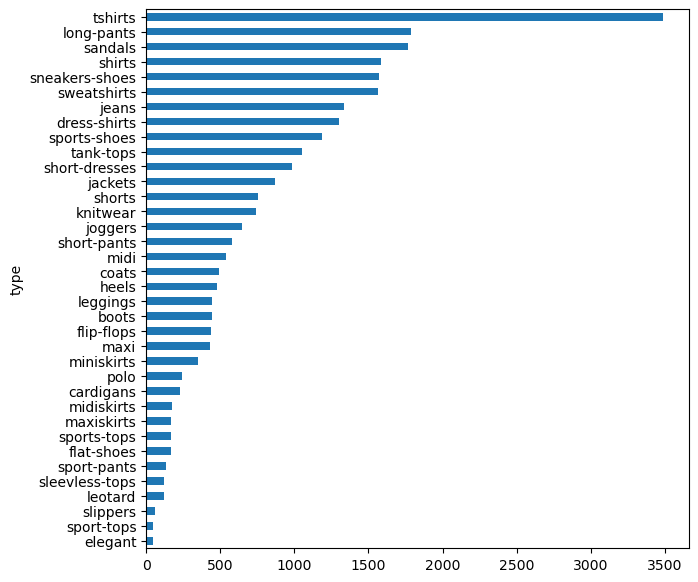

In [3]:
plt.figure(figsize=(7,7))
df.type.value_counts().sort_values().plot(kind='barh')

In [ ]:
# Load the pre-trained ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the pre-trained base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=x)

# Function to preprocess image and generate embedding
def get_embedding(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    embedding = model.predict(x)
    return embedding.flatten()

# Generate embeddings for all items in the dataset
df['embedding'] = df['image_path'].apply(lambda x: get_embedding(model, x))

# Convert list of embeddings to a DataFrame
embeddings = np.vstack(df['embedding'].values)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


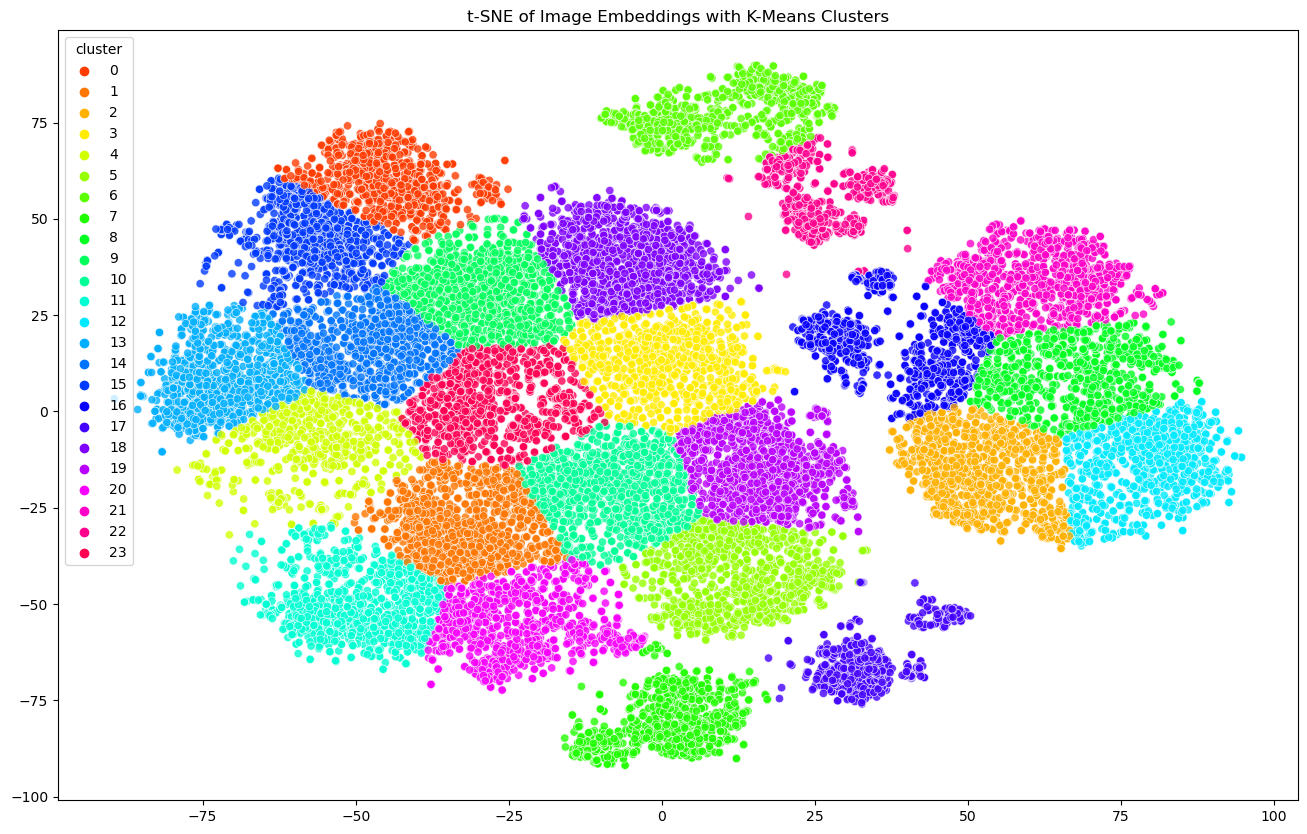

In [67]:
# Step 1: Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)

# Step 2: Apply K-Means clustering to create clusters
num_clusters = 24
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(tsne_embeddings)

# Step 3: Add gender information to clusters
df['gender_cluster'] = df['gender'] + '_cluster_' + df['cluster'].astype(str)

# Plot t-SNE results with clusters
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1],
    hue=df['cluster'],
    palette=sns.color_palette("hsv", num_clusters),
    legend="full",
    alpha=0.8
)
plt.title('t-SNE of Image Embeddings with K-Means Clusters')
plt.show()

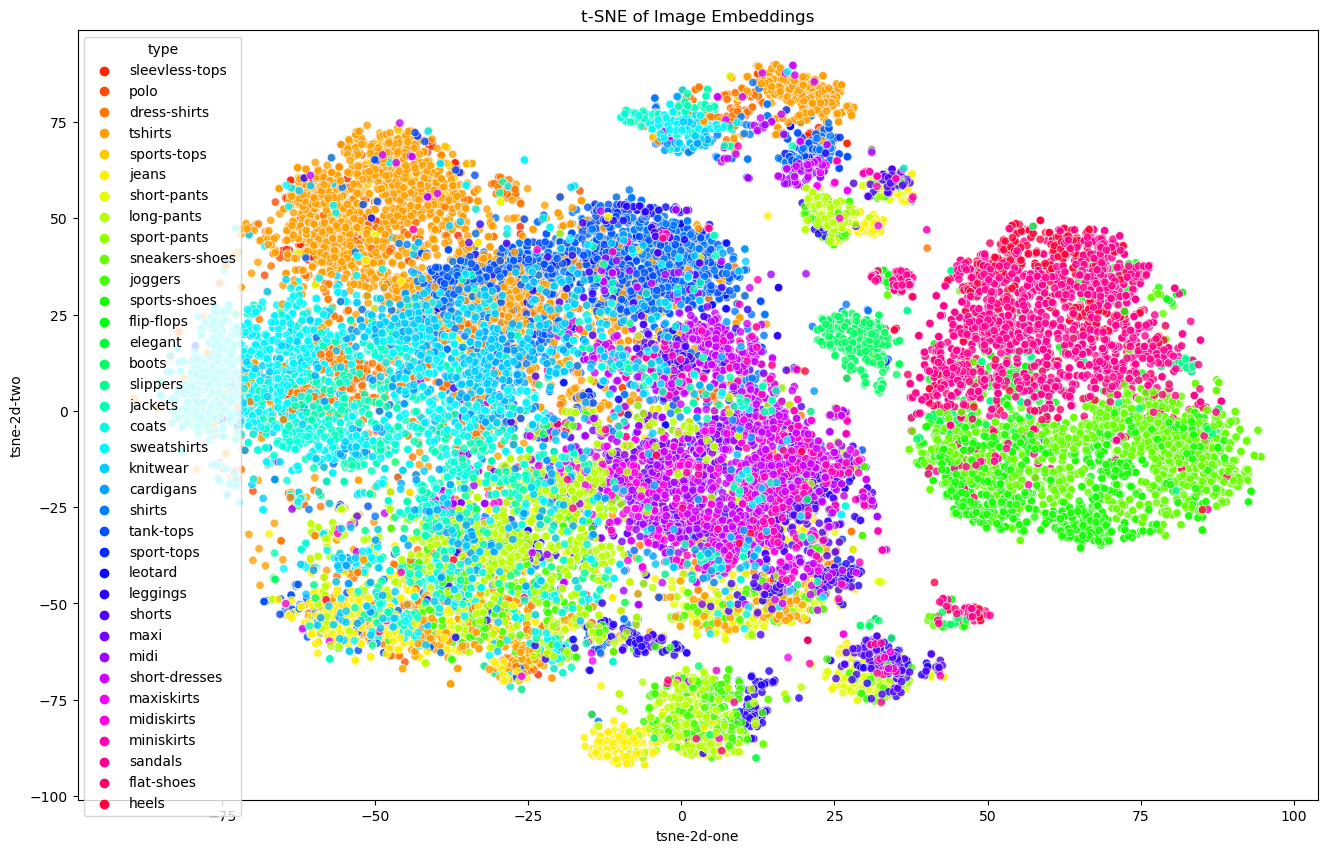

In [68]:
# Plot t-SNE results
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="type",  # Change this to any column you want to color by
    palette=sns.color_palette("hsv", len(df['type'].unique())),
    data=df,
    legend="full",
    alpha=0.8
)
plt.title('t-SNE of Image Embeddings')
plt.show()

In [51]:
# Compute cosine similarity between all embeddings
cosine_sim = 1 - pairwise_distances(embeddings, metric='cosine')


In [52]:
# Function to get recommendations based on cosine similarity and clustering, filtered by gender
def get_recommender(idx, df, top_n=5):
    gender_cluster = df.iloc[idx]['gender_cluster']
    cluster_items = df[df['gender_cluster'] == gender_cluster].index
    sim_scores = [(i, cosine_sim[idx][i]) for i in cluster_items]
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # Exclude the first one as it is the item itself
    idx_rec = [i[0] for i in sim_scores]
    sim_values = [i[1] for i in sim_scores]
    recommended_items = df.iloc[idx_rec]
    return recommended_items, sim_values


In [53]:
# Compute class centers
class_centers = df.groupby('category')['embedding'].apply(lambda x: np.mean(np.vstack(x), axis=0)).to_dict()


In [54]:
# Calculate distances to class centers for threshold calculation
distances = []
for idx in range(len(df)):
    embedding = df.loc[idx, 'embedding']
    category = df.loc[idx, 'category']
    class_center = class_centers.get(category)
    if class_center is not None:
        distance = np.linalg.norm(class_center - embedding)
        distances.append(distance)

# Compute thresholds based on distances
percentiles = [51, 70, 85, 95]
thresholds = np.percentile(distances, percentiles)

In [63]:
def calculate_uniqueness(new_embedding, class_center, thresholds):
    # Calculate the distance from the class center
    distance = np.linalg.norm(class_center - new_embedding)
    
    # Determine uniqueness levels based on thresholds
    if distance <= thresholds[0]:
        uniqueness_level = "Basic"
    elif distance <= thresholds[1]:
        uniqueness_level = "Stylish"
    elif distance <= thresholds[2]:
        uniqueness_level = "Trend Setter"
    elif distance <= thresholds[3]:
        uniqueness_level = "Bold & unique"
    else:
        uniqueness_level = "Fashion Pioneer"
    
    return uniqueness_level, distance


In [64]:
# Test the recommender with a specific item index

idx_test = 700 # Change this to test with different items
recommended_df, sim_values = get_recommender(idx_test, df, top_n=6)

print("Recommended Items:")
print(recommended_df[['type', 'color', 'gender','category']])

# Calculate uniqueness for the test item
test_embedding = df.loc[idx_test, 'embedding']
category = df.loc[idx_test, 'category']
class_center = class_centers.get(category)
if class_center is not None:
    uniqueness_level, distance = calculate_uniqueness(test_embedding, class_center, thresholds)
    print(f"Uniqueness Level: {uniqueness_level}, Distance from class center: {distance:.2f}")
else:
    print(f"No class center found for category: {category}")


Recommended Items:
            type  color gender    category
3542  long-pants  10048    men  Bottomwear
2376     tshirts     10    men     Topwear
3608  long-pants   9998    men  Bottomwear
3540  long-pants   2148    men  Bottomwear
1259       jeans      4    men  Bottomwear
4312     joggers      4    men  Bottomwear
Uniqueness Level: Basic, Distance from class center: 20.27


In [65]:
def check_uniqueness_for_items(start_idx, end_idx, class_centers, thresholds, df):
    # Initialize counters for each uniqueness level
    level_counts = {
        "Basic": 0,
        "Stylish": 0,
        "Trend Setter": 0,
        "Bold & unique": 0,
        "Fashion Pioneer": 0
    }
    
    # Iterate through the range of indices
    for idx_test in range(start_idx, end_idx):
        test_embedding = df.loc[idx_test, 'embedding']
        category = df.loc[idx_test, 'category']
        class_center = class_centers.get(category)
        if class_center is not None:
            uniqueness_level, _ = calculate_uniqueness(test_embedding, class_center, thresholds)
            # Update the count for the corresponding uniqueness level
            if uniqueness_level in level_counts:
                level_counts[uniqueness_level] += 1

    return level_counts

# Calculate distances and thresholds
distances = []
for idx in range(len(df)):
    embedding = df.loc[idx, 'embedding']
    category = df.loc[idx, 'category']
    class_center = class_centers.get(category)
    if class_center is not None:
        distance = np.linalg.norm(class_center - embedding)
        distances.append(distance)
# Check uniqueness for the range of items
level_counts = check_uniqueness_for_items(0, len(df), class_centers, thresholds, df)

# Display the count of items in each uniqueness level
print("\nTotal Count of Items in Each Uniqueness Level:")
for level, count in level_counts.items():
    print(f"{level}: {count}")



Total Count of Items in Each Uniqueness Level:
Basic: 13508
Stylish: 5032
Trend Setter: 3973
Bold & unique: 2648
Fashion Pioneer: 1325


In [66]:
# Function to plot figures
def plot_figures(figures, nrows=1, ncols=1, figsize=(12, 8)):
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    for ind, title in enumerate(figures):
        axeslist.ravel()[ind].imshow(plt.imread(figures[title]))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout()

# Plot the test image
plt.imshow(plt.imread(df.iloc[idx_test].image_path))
plt.title('Test Image')
plt.axis('off')
plt.show()

# Generate a dictionary of (title, images) for recommendations
figures = {f'Recommended {i+1}': row.image_path for i, row in recommended_df.iterrows()}

# Plot the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)
plt.show()


Recommended Items for image 4322:
             type color gender    category
3708      tshirts    21    men     Topwear
3351  sport-pants     4    men  Bottomwear
3456  sport-pants     4    men  Bottomwear
4580      joggers     4    men  Bottomwear
1560        jeans     4    men  Bottomwear
510       tshirts    21    men     Topwear
Uniqueness Level: Level 1 (Least Unique), Distance from class center: 18.17


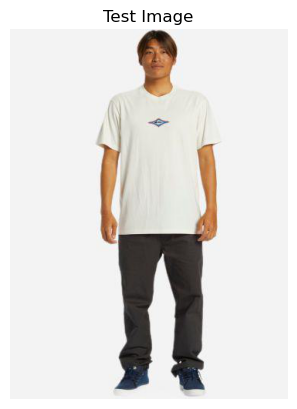

Recommended Items for image 7624:
             type color gender category
8215  sweatshirts     4    men  Topwear
7646  sweatshirts     4    men  Topwear
8241  sweatshirts     9    men  Topwear
9546  sweatshirts     4    men  Topwear
7663  sweatshirts     4    men  Topwear
7670  sweatshirts     4    men  Topwear
Uniqueness Level: Level 4, Distance from class center: 28.61


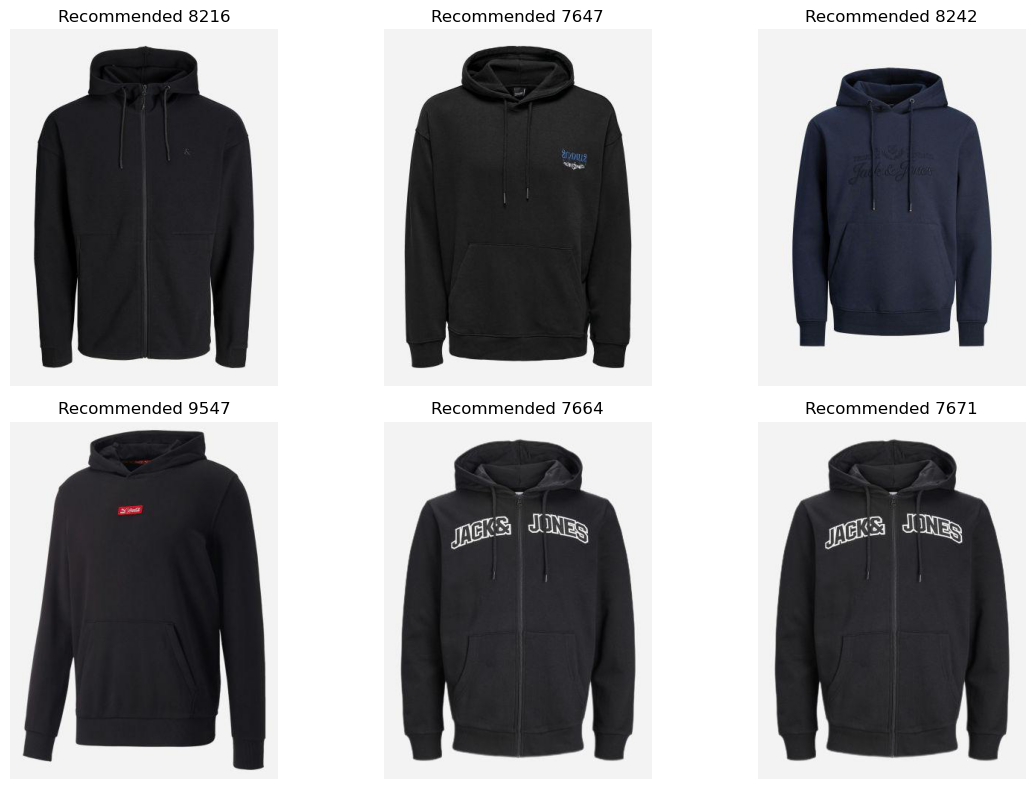

Recommended Items for image 17269:
                type  color gender    category
20293     miniskirts      4  women  Bottomwear
20423  short-dresses      4  women  Bottomwear
16119         shorts      4  women  Bottomwear
13652         shirts      4  women     Topwear
15579         shorts      4  women  Bottomwear
19272  short-dresses  10115  women  Bottomwear
Uniqueness Level: Level 1 (Least Unique), Distance from class center: 17.25


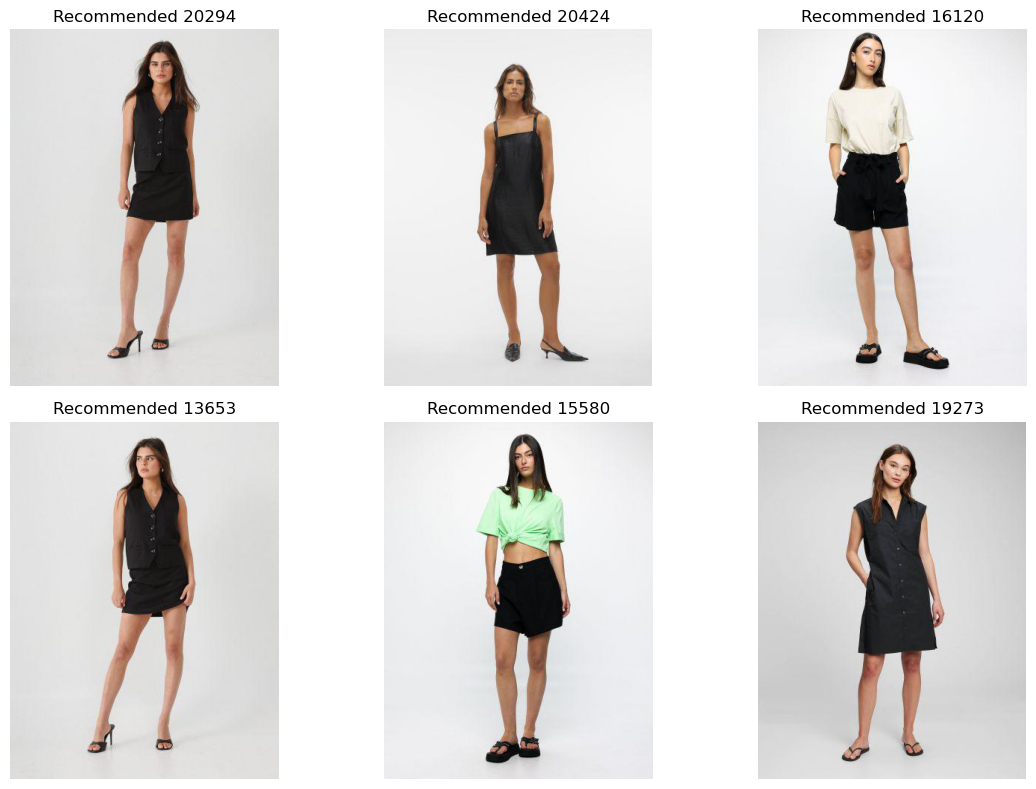

Recommended Items for image 4562:
            type  color gender    category
2975  long-pants  17762    men  Bottomwear
4141  long-pants   2148    men  Bottomwear
4143  long-pants  17762    men  Bottomwear
4572     joggers    106    men  Bottomwear
4603     joggers  10290    men  Bottomwear
2983  long-pants  17762    men  Bottomwear
Uniqueness Level: Level 4, Distance from class center: 29.74


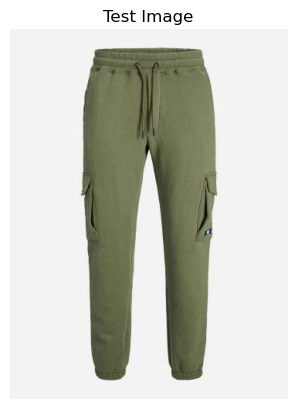

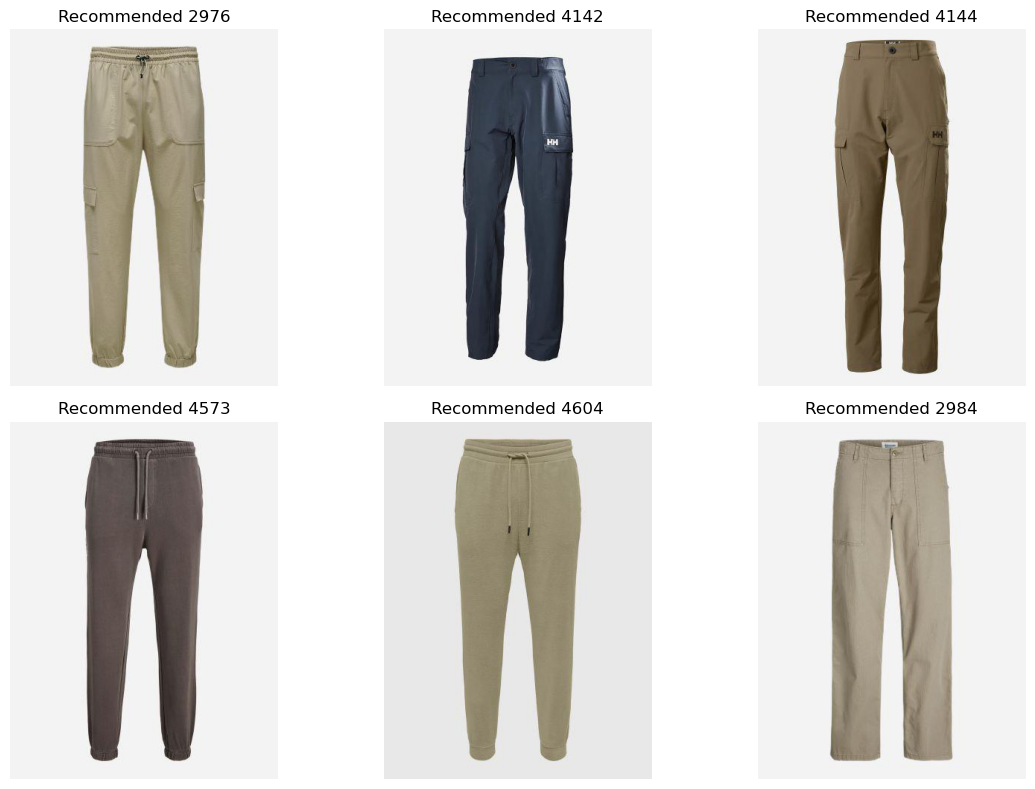

Recommended Items for image 18757:
             type  color gender    category
18501  midiskirts   8621  women  Bottomwear
13944       jeans    467  women  Bottomwear
14184       jeans      9  women  Bottomwear
16753      shorts  10101  women  Bottomwear
16235      shorts  18786  women  Bottomwear
15992      shorts  20799  women  Bottomwear
Uniqueness Level: Level 2, Distance from class center: 22.25


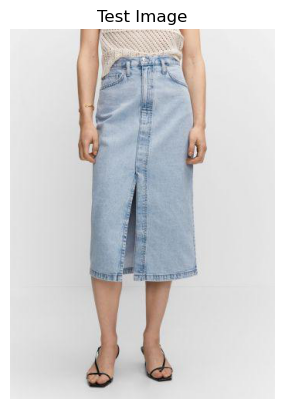

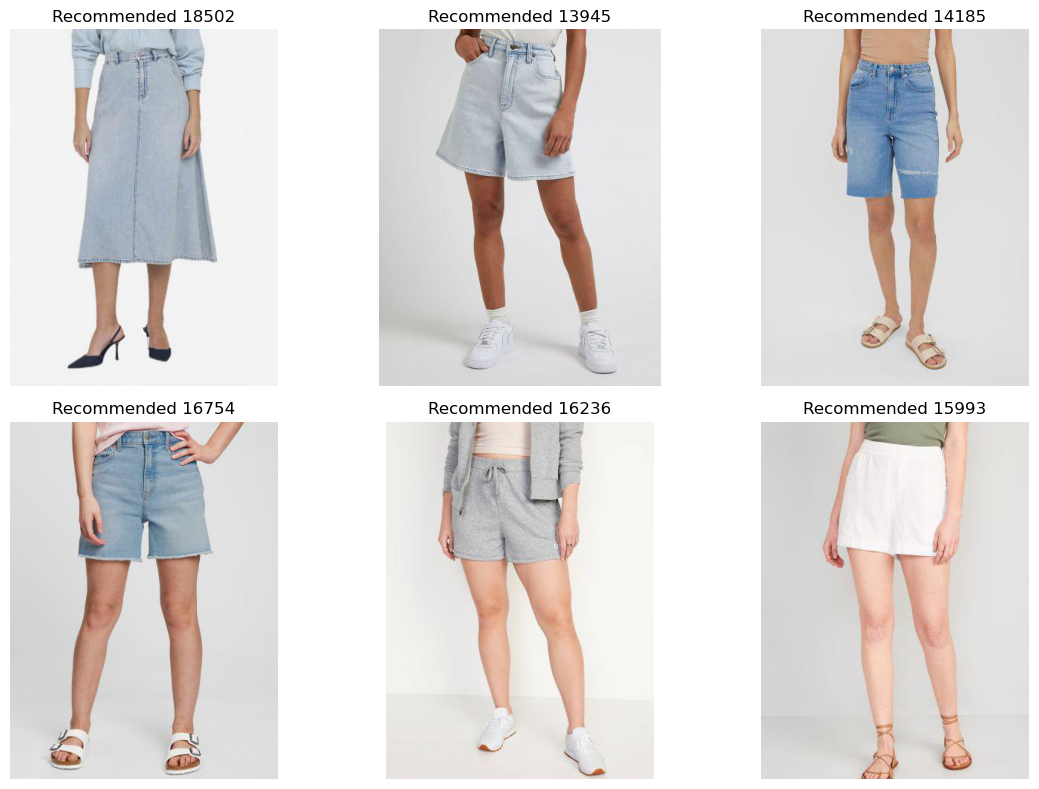

Recommended Items for image 14138:
         type  color gender    category
13783   jeans      9  women  Bottomwear
13345   jeans   9153  women  Bottomwear
16753  shorts  10101  women  Bottomwear
14965   jeans      9  women  Bottomwear
15026  shorts      9  women  Bottomwear
13329   jeans     21  women  Bottomwear
Uniqueness Level: Level 2, Distance from class center: 23.33


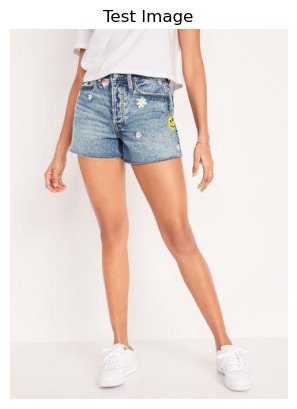

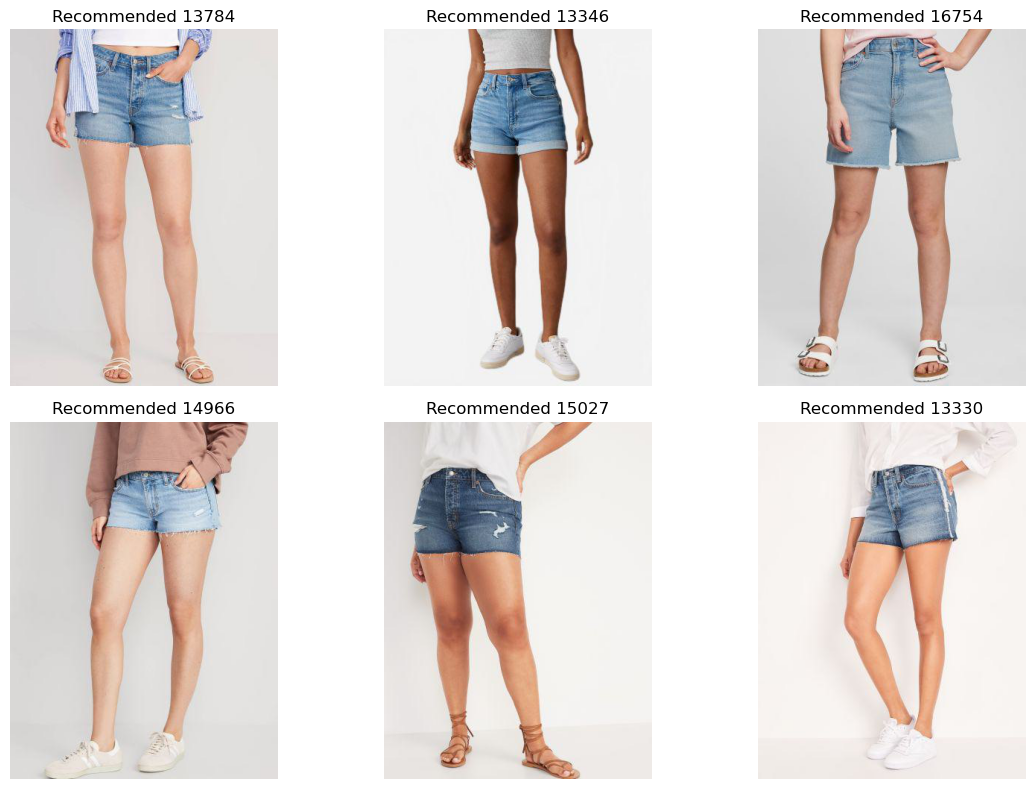

Recommended Items for image 25226:
                type  color gender    category
16330         shorts     22  women  Bottomwear
16008         shorts     10  women  Bottomwear
16954         shorts     10  women  Bottomwear
17386  short-dresses     10  women  Bottomwear
19865  short-dresses  11622  women  Bottomwear
18718           midi     10  women  Bottomwear
Uniqueness Level: Level 2, Distance from class center: 24.17


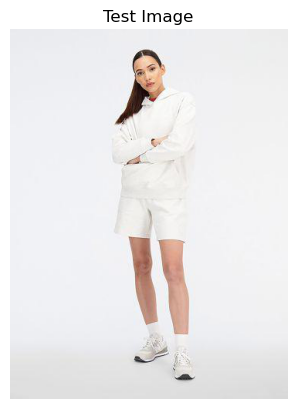

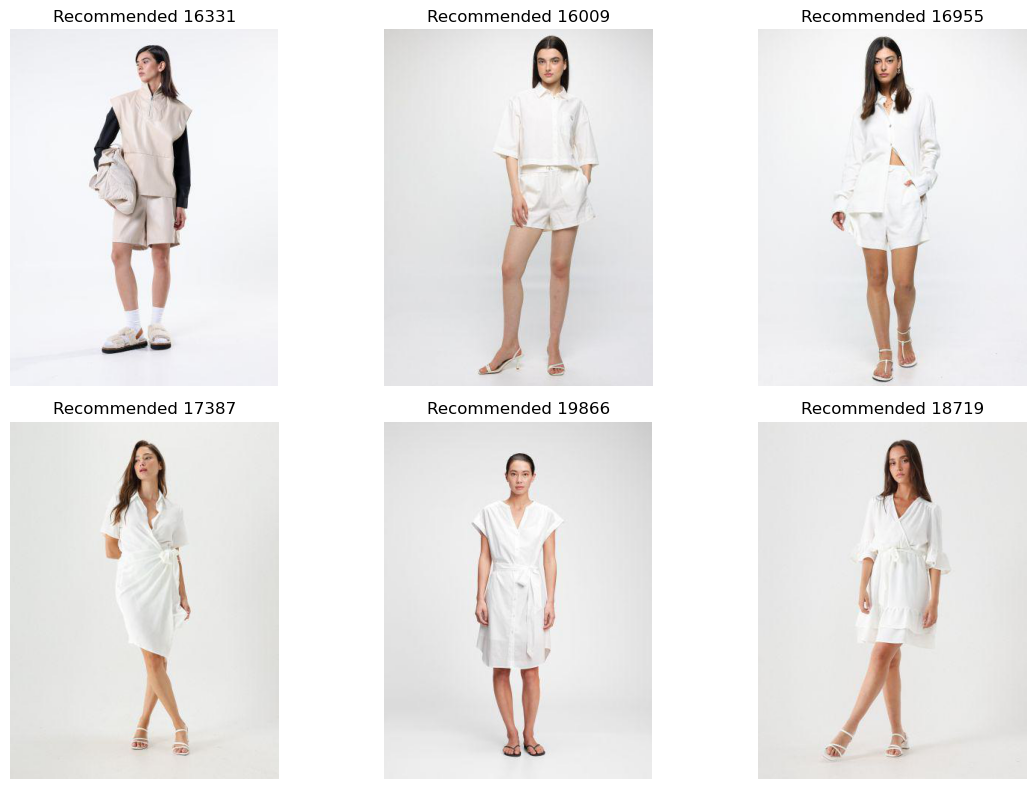

Recommended Items for image 135:
               type color gender category
377  sleevless-tops    10    men  Topwear
152  sleevless-tops   111    men  Topwear
156  sleevless-tops  8924    men  Topwear
218  sleevless-tops    10    men  Topwear
52   sleevless-tops    21    men  Topwear
210  sleevless-tops     5    men  Topwear
Uniqueness Level: Level 1 (Least Unique), Distance from class center: 21.09


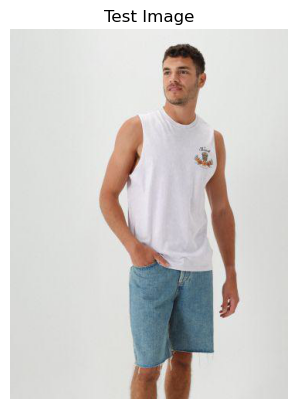

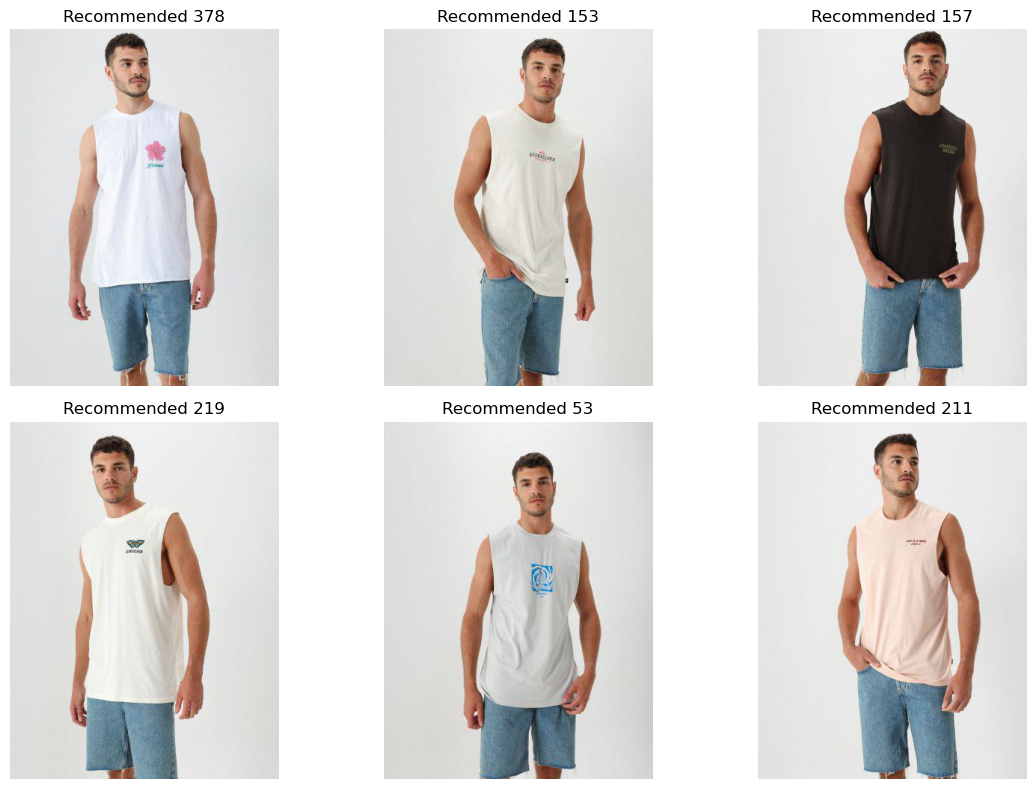

Recommended Items for image 19313:
                type color gender    category
11622   dress-shirts    10  women     Topwear
19134     miniskirts    10  women  Bottomwear
20176  short-dresses     9  women  Bottomwear
14731         shorts    10  women  Bottomwear
20506  short-dresses   116  women  Bottomwear
19220     miniskirts     8  women  Bottomwear
Uniqueness Level: Level 1 (Least Unique), Distance from class center: 18.43


Recommended Items for image 10731:
            type  color gender category
12438     shirts   9187  women  Topwear
12691  tank-tops  21235  women  Topwear
12437     shirts   4448  women  Topwear
9025      shirts    100  women  Topwear
13334     shirts   2095  women  Topwear
11008  tank-tops      9  women  Topwear
Uniqueness Level: Level 4, Distance from class center: 32.47


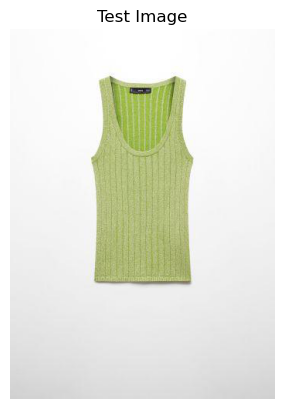

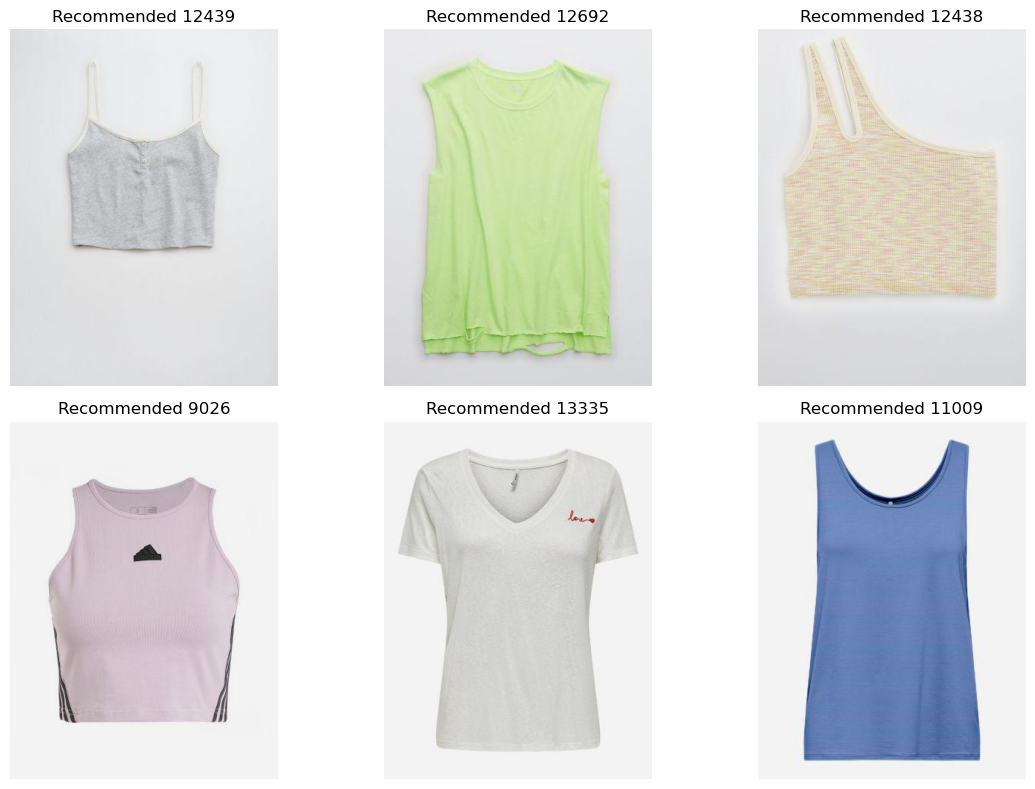

In [59]:
import random

# Generate recommendations for 10 random images
num_recommendations = 10
random_indices = random.sample(range(len(df)), num_recommendations)

for idx_test in random_indices:
    recommended_df, sim_values = get_recommender(idx_test, df, top_n=6)

    print(f"Recommended Items for image {idx_test}:")
    print(recommended_df[['type', 'color', 'gender', 'category']])

    # Calculate uniqueness for the test item
    test_embedding = df.loc[idx_test, 'embedding']
    class_center = class_centers[df.loc[idx_test, 'category']]
    uniqueness_level, distance = calculate_uniqueness(test_embedding, class_center, thresholds)
    print(f"Uniqueness Level: {uniqueness_level}, Distance from class center: {distance:.2f}")

    # Plot the test image
    plt.figure()
    plt.imshow(plt.imread(df.iloc[idx_test].image_path))
    plt.title('Test Image')
    plt.axis('off')
    plt.show()

    # Generate a dictionary of (title, images) for recommendations
    figures = {f'Recommended {i+1}': row.image_path for i, row in recommended_df.iterrows()}

    # Plot the images in a figure, with 2 rows and 3 columns
    plot_figures(figures, 2, 3)
    plt.show()


In [49]:
# Save the sample, embeddings, and metadata to CSV files
df_sample = df.sample(10)
df_sample.to_csv('df_sample.csv', index=False)

# Convert the embeddings to a DataFrame
embeddings_df = pd.DataFrame(embeddings)
embeddings_df.to_csv('embeddings.csv', index=False)

# Save the complete metadata
df.to_csv('metadados.csv', index=False)
